In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Experiment for gradient calc

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

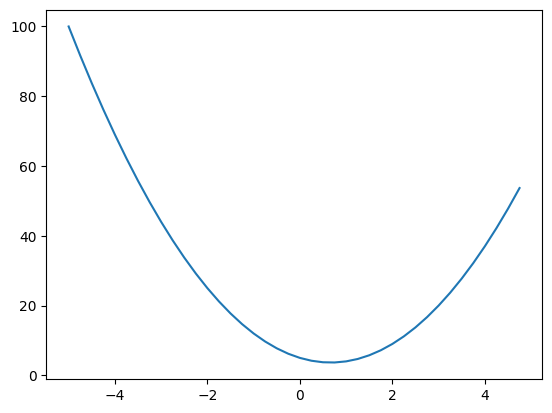

In [4]:
xs = np.arange(-5.0,5.0,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.0001

a = 2.0
b = -3.0
c = 10

print("w.r.t c")
d1 = a*b + c
c += h
d2 = a*b + c
print(f"d1= {d1} d2= {d2}")
print(f"slope= {(d2 - d1) / h} ")

print()
print("w.r.t a")
d1 = a*b + c
a += h
d2 = a*b + c
print(f"d1= {d1} d2= {d2}")
print(f"slope= {(d2 - d1) / h} ")

print()
print("w.r.t b")
d1 = a*b + c
b += h
d2 = a*b + c
print(f"d1= {d1} d2= {d2}")
print(f"slope= {(d2 - d1) / h} ")



w.r.t c
d1= 4.0 d2= 4.0001
slope= 0.9999999999976694 

w.r.t a
d1= 4.0001 d2= 3.9997999999999987
slope= -3.000000000010772 

w.r.t b
d1= 3.9997999999999987 d2= 4.00000001
slope= 2.0001000000124947 


## Value class 

In [20]:
class Value:
    
    def __init__(self,data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __rsub__(self,other):
        return (-self) + other
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    
        return out
    
    def __radd__(self,other):
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self,other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self * other
    
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supports int/float for the power"
        out =  Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    
    def __truediv__(self,other):
        return self * other ** -1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1.0 - (t ** 2)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                visited.add(v)
        build_topo(self)
        
        self.grad = 1
        
        for elem in reversed(topo):
            elem._backward()
            


In [21]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [22]:
a = Value(2.0)
1 + a

Value(data=3.0)

In [23]:
a = Value(2.0)
a - 1

Value(data=1.0)

In [24]:
a = Value(2.0)
a * 1

Value(data=2.0)

In [25]:
a = Value(2.0)
1 * a

Value(data=2.0)

In [26]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [27]:
a = Value(2.0)
b = Value(3.0)
a / b

Value(data=0.6666666666666666)

In [28]:
a = Value(2.0)
b = Value(3.0)
a - b

Value(data=-1.0)

## Visualizer of graph

In [15]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR->left to right
    
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" %(n.label, n.data, n.grad), shape='record')
        if n._op:
            # operation node
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



In [29]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'

d = e + c; d.label='d'

f = Value(-2.0, label = 'f')

L = d * f; L.label='L'


print(L)

print(L._prev)

print(L._op)

Value(data=-8.0)
{Value(data=4.0), Value(data=-2.0)}
*


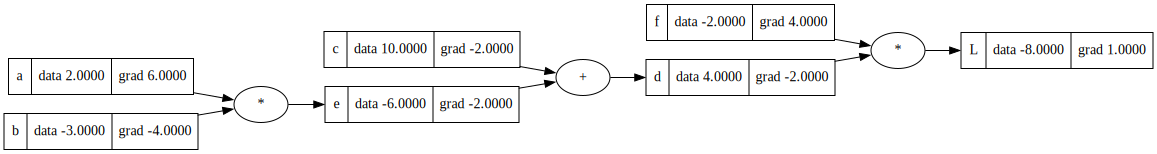

In [33]:
draw_dot(L)

In [32]:
L.grad = 1
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0

a.grad = -2.0 * -3.0
b.grad = -2.0 * 2

## Tanh activation

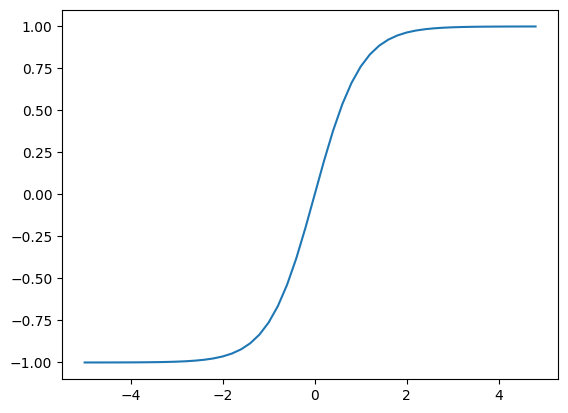

In [24]:
xs = np.arange(-5,5,0.2)
ys = np.tanh(np.arange(-5,5,0.2))

plt.plot(xs,ys)

In [35]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2';

n = x1w1x2w2 + b; n.label = 'n';

# o = n.tanh(); o.label = 'o';
e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'


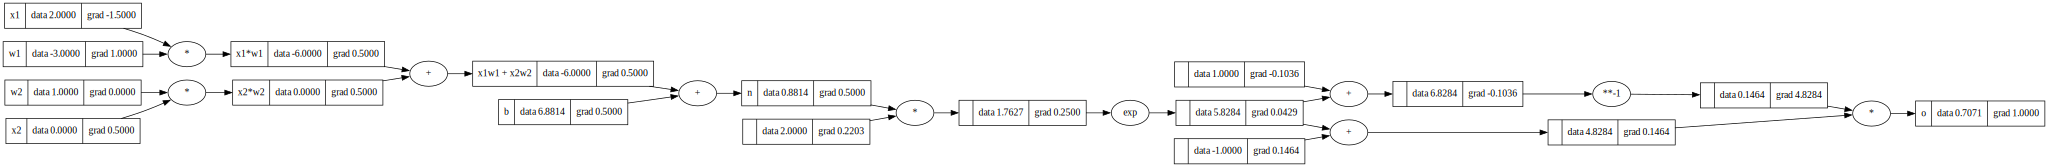

In [40]:
draw_dot(o)

In [37]:
o.backward()

In [38]:

##Manual backprop
# o.grad = 1
# n.grad = 1 - (o.data ** 2)
# b.grad = n.grad
# x1w1x2w2.grad = n.grad
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

##call backward
# o.grad = 1
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# b._backward() # Not necessary: Leaf node
# x1w1._backward()
# x2w2._backward()

## Topo sort and call backward
# o.grad = 1
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
#         visited.add(v)
# build_topo(o)
# for elem in reversed(topo):
#     elem._backward()


In [39]:
# Topological 

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        for child in v._prev:
            build_topo(child)
        topo.append(v)
        visited.add(v)
build_topo(o)
topo

[Value(data=-1),
 Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=2),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=4.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=0.7071067811865477)]

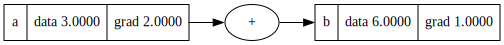

In [41]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b';
b.backward()
draw_dot(b)

In [42]:
import torch

# inputs x1, x2
x1 = torch.Tensor([2.0]).double();     x1.requires_grad = True;
x2 = torch.Tensor([0.0]).double();     x2.requires_grad = True;

# weights w1, w2
w1 = torch.Tensor([-3.0]).double();     w1.requires_grad = True;
w2 = torch.Tensor([1.0]).double();     w2.requires_grad = True;

# bias
b = torch.Tensor([6.8813735870195432]).double();     b.requires_grad = True;

n = x1*w1 + x2*w2 + b; 

o = torch.tanh(n);
print(o.data.item());
o.backward()

print(x1.grad);
print(x2.grad);

print(w1.grad);
print(w2.grad);



0.7071066904050358
tensor([-1.5000], dtype=torch.float64)
tensor([0.5000], dtype=torch.float64)
tensor([1.0000], dtype=torch.float64)
tensor([0.], dtype=torch.float64)


## Perceptron

In [39]:
random.uniform(-1,1)

0.5919328642523223

In [43]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params   
    


In [112]:
x = [2.0, 3.0, -1.0]

# n = Neuron(2)
# n = Layer(2, 3)
n = MLP(3, [4,4,1])

n(x)
print(len(n.parameters()))

41


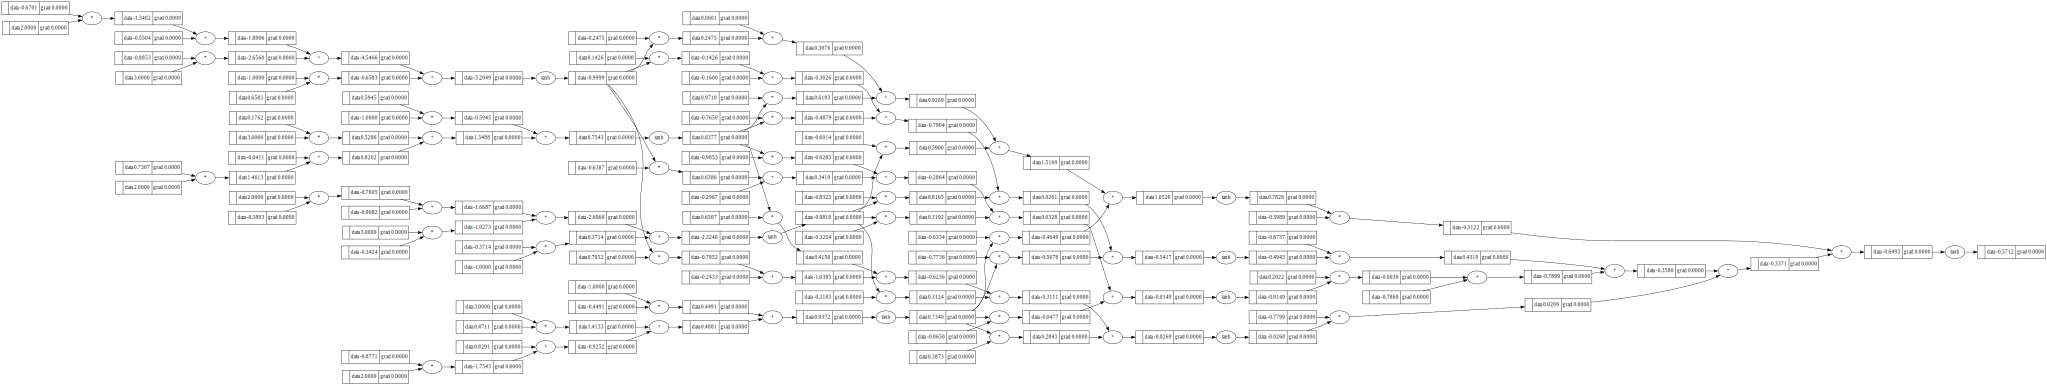

In [62]:
draw_dot(n(x))

In [113]:
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1],
]
ys = [1,-1,-1,1]

## Backprop decrypted

In [143]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))

In [115]:
loss

Value(data=6.384625750164675)

In [144]:
loss

Value(data=0.08157803196262028)

In [138]:
for p in n.parameters():
    p.grad = 0.0

In [139]:
loss.backward()

In [140]:
n.layers[0].neurons[0].w[0].grad

0.044130062504411656

In [141]:
n.layers[0].neurons[0].w[0].data

-0.09762633934076087

In [142]:
for p in n.parameters():
    p.data += -(0.09* p.grad)

In [145]:
ypred

[Value(data=0.8931751107008291),
 Value(data=-0.8496347340563474),
 Value(data=-0.8177102126156364),
 Value(data=0.8803037377279546)]